In [1]:
import scanpy as sc
from scipy.sparse import csr_matrix
sc.set_figure_params(dpi=80)
import csv
from numpy import savetxt


# Construct AnnData object of FLE set

## Counts

In [2]:
FLE = sc.read_mtx("FLEcounts_scaled_v2.mtx")

In [3]:
FLE

AnnData object with n_obs × n_vars = 30000 × 18260 

## Cell barcodes

In [ ]:
FLEobsCSV = open('FLEobs_scaled_v2.csv')
csv_f = csv.reader(FLEobsCSV)

FLEobs = []

for row in csv_f:
    FLEobs.append(row[1])

#print(len(FLEobs))
del FLEobs[0]
#print(len(FLEobs))
#print(FLEobs)


In [5]:
FLE.obs_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '29990', '29991', '29992', '29993', '29994', '29995', '29996', '29997',
       '29998', '29999'],
      dtype='object', length=30000)

In [6]:
FLE.obs_names = FLEobs

## Gene names

In [ ]:
FLEvarCSV = open('FLEvar_scaled_v2.csv')
csv_f = csv.reader(FLEvarCSV)

FLEvar = []

for row in csv_f:
    FLEvar.append(row[1])

print(len(FLEvar))
del FLEvar[0]
print(len(FLEvar))
print(FLEvar)


In [10]:
FLE.var_names = FLEvar

In [12]:
csr_matrix.sum(FLE.X[0,:]) #matches sum(FLEcounts_t[1,]) in R

3776.731

## Age

In [24]:
ageCSV = open('FLEage_scaled_v2.csv')
csv_f = csv.reader(ageCSV)

FLEage = []

for row in csv_f:
    FLEage.append(row[0])


In [25]:
FLE.obs['Age'] = FLEage

In [26]:
FLE.obs

,Age
aRGC2_CACCACTGTCTAGTCA-1,P56
P0L1camRGCS1_TAAACCGAGCAGACTG-1,P0
aRGC9_ATTGGACTCGGCGGTT-1,P56
P5Cd90RGCS7_TAAGGGAGCAGA,P5
E14L1camRGCS2_GAGAGGTTCTCTCTAA,E14
...,...
aRGC7_AGAGTGGAGATAGGAG-1,P56
P0Cd90RGCS1_GGTGTTATCTGCAAGT-1,P0
aRGC7_GTAGTCAAGTCGTACT-1,P56
aRGC7_AGCTTGAGTAAAGGAG-1,P56


## Module Scores

In [27]:
FLE.X

<30000x18260 sparse matrix of type '<class 'numpy.float32'>'
	with 98540638 stored elements in Compressed Sparse Row format>

In [28]:
print(FLE.X.sum(axis=1).A1, "non-integers show that these are logTPM counts")

[3776.6277 3006.726  3796.592  ... 3721.4287 3751.5244 3607.6619] integers show that these are raw counts


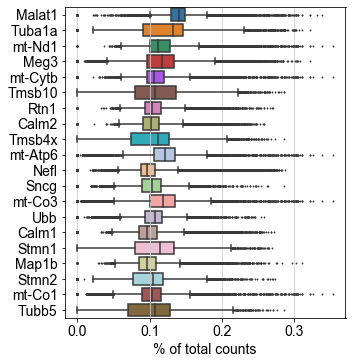

In [29]:
sc.pl.highest_expr_genes(FLE, n_top=20, ) 

### Normalize and log (unnecessary if performed prior)

In [30]:
#sc.pp.normalize_per_cell(FLE, counts_per_cell_after=1e4)
#sc.pp.log1p(FLE)

In [31]:
#sc.pl.highest_expr_genes(FLE, n_top=20, ) #

In [32]:
#print(FLE.X.sum(axis=1).A1, "no longer raw")

In [33]:
import numpy as np
import scanpy as sc
from anndata import AnnData
from typing import Union, Optional, Tuple, Collection, Sequence, Iterable

def module_score(
    adata:AnnData,
    genes_use: list,
    score_name: Optional[str] = None,
    verbose: bool = True):
    
    """\
    Compute module scores for all cells in adata as described in methods of RGC-dev paper.
    
    
    Parameters
    ----------
    adata
        The (annotated) data matrix of shape `n_obs` × `n_vars`.
        Rows correspond to cells and columns to genes.
    genes_use
        list of genes in module of interest
    score_name
        Name endowed to the module score to be computed
        e.g. "Mod1"
    verbose
        Inform user of fraction of module genes that are in adata
        
    Returns
    -------
    adata with a new .obs called score_name
    
    """
    
    if (score_name==None):
        score_name = str(input("Provide a name for this score (no spaces): "))
        
    genes_use0 = genes_use
    genes_use = list(set(genes_use).intersection(adata.var_names))#genes that are both in module and `adata`
    
     
    if (len(genes_use) == 0):
        raise ValueError("Error : Must provide a list of genes that are present in the data")
        
    
    if (verbose):
        if(len(genes_use0) > len(genes_use)):
            n = len(genes_use0) - len(genes_use)
            print("Note that", n, "of the", len(genes_use0), "genes in your module do not exist in the data set." )
    
    
    
    adata_score = adata.copy()
    adata_score = adata[:,genes_use]
    
    counts_modgenes = adata_score.X.toarray() #all cells, module genes
    counts_all = adata.X.toarray() #all cells, all genes
    scores = np.mean(counts_modgenes, axis=1) - np.mean(counts_all, axis=1) #(row means of counts_modgenes ) - (row means of counts_all)
    
    adata.obs[score_name] = scores

Read in module of interest

In [34]:
with open('../modules/mod1.txt', 'r') as f:
    mod1 = [line.strip() for line in f]
len(mod1)

185

### Compute scores for mod 1

In [35]:
module_score(FLE, mod1, "Module 1 Score")
FLE.obs

,Age,Module 1 Score
aRGC2_CACCACTGTCTAGTCA-1,P56,0.136857
P0L1camRGCS1_TAAACCGAGCAGACTG-1,P0,0.201085
aRGC9_ATTGGACTCGGCGGTT-1,P56,0.165002
P5Cd90RGCS7_TAAGGGAGCAGA,P5,0.413848
E14L1camRGCS2_GAGAGGTTCTCTCTAA,E14,0.771272
...,...,...
aRGC7_AGAGTGGAGATAGGAG-1,P56,0.119992
P0Cd90RGCS1_GGTGTTATCTGCAAGT-1,P0,0.089230
aRGC7_GTAGTCAAGTCGTACT-1,P56,0.093950
aRGC7_AGCTTGAGTAAAGGAG-1,P56,0.158449


In [36]:
mod1_score = FLE.obs['Module 1 Score'].array

In [37]:
np.array(mod1_score)

array([0.13685697, 0.20108509, 0.16500184, ..., 0.09395048, 0.15844871,
       0.1493343 ], dtype=float32)

In [38]:
savetxt('mod1.csv', mod1_score, delimiter=',')

### Compute scores for mods 2-6


In [39]:
with open('../modules/mod2.txt', 'r') as f:
    mod2 = [line.strip() for line in f]
print(len(mod2))

with open('../modules/mod3.txt', 'r') as f:
    mod3 = [line.strip() for line in f]
print(len(mod3))

with open('../modules/mod4.txt', 'r') as f:
    mod4 = [line.strip() for line in f]
print(len(mod4))

with open('../modules/mod5.txt', 'r') as f:
    mod5 = [line.strip() for line in f]
print(len(mod5))

with open('../modules/mod6.txt', 'r') as f:
    mod6 = [line.strip() for line in f]
print(len(mod6))

192
152
198
236
644


In [40]:
module_score(FLE, mod2, "Module 2 Score")
module_score(FLE, mod3, "Module 3 Score")
module_score(FLE, mod4, "Module 4 Score")
module_score(FLE, mod5, "Module 5 Score")
module_score(FLE, mod6, "Module 6 Score")


In [42]:
mod2_score = FLE.obs['Module 2 Score'].array
mod3_score = FLE.obs['Module 3 Score'].array
mod4_score = FLE.obs['Module 4 Score'].array
mod5_score = FLE.obs['Module 5 Score'].array
mod6_score = FLE.obs['Module 6 Score'].array

In [43]:
savetxt('mod2.csv', mod2_score, delimiter=',')
savetxt('mod3.csv', mod3_score, delimiter=',')
savetxt('mod4.csv', mod4_score, delimiter=',')
savetxt('mod5.csv', mod5_score, delimiter=',')
savetxt('mod6.csv', mod6_score, delimiter=',')

In [44]:
FLE.obs

,Age,Module 1 Score,Module 2 Score,Module 3 Score,Module 4 Score,Module 5 Score,Module 6 Score
aRGC2_CACCACTGTCTAGTCA-1,P56,0.136857,0.341250,0.498113,0.320300,0.526644,0.687323
P0L1camRGCS1_TAAACCGAGCAGACTG-1,P0,0.201085,1.380941,1.345515,0.242314,0.073126,0.190261
aRGC9_ATTGGACTCGGCGGTT-1,P56,0.165002,0.628985,0.914334,0.303899,0.436711,0.781643
P5Cd90RGCS7_TAAGGGAGCAGA,P5,0.413848,0.444092,0.495282,0.841306,0.740458,0.259005
E14L1camRGCS2_GAGAGGTTCTCTCTAA,E14,0.771272,1.482833,0.653049,0.387327,0.080544,0.135604
...,...,...,...,...,...,...,...
aRGC7_AGAGTGGAGATAGGAG-1,P56,0.119992,0.630980,0.728029,0.286554,0.359441,0.710768
P0Cd90RGCS1_GGTGTTATCTGCAAGT-1,P0,0.089230,1.083271,1.389340,0.166997,0.036843,0.144843
aRGC7_GTAGTCAAGTCGTACT-1,P56,0.093950,0.736685,1.087866,0.183413,0.309034,0.732420
aRGC7_AGCTTGAGTAAAGGAG-1,P56,0.158449,0.590410,0.941856,0.312917,0.442693,0.827198


### Plot modules

In [45]:
import pandas as pd
FLEcoords = pd.read_csv('FLEcoords.csv', delimiter=',', index_col=0)

In [46]:
FLEcoords

,FLE 1,FLE 2
Cell name,,
E16Cd90RGCS1_GCATGCGTCATGTCTT-1,2921.63344,1047.42991
E14L1camRGCS1_ACTTACTCATTAGGCT-1,3703.59245,2294.68441
P5Cd90RGCS2_GAAAATTACGAC,45.59943,330.59214
P0Cd90RGCS1_GAAGCAGCATACTCTT-1,1643.91878,822.44501
E14L1camRGCS2_CATTTCACATGAAAGT,4411.13016,2518.81826
...,...,...
P0L1camRGCS1_AGTGTCAGTCGGCACT-1,1517.04060,724.51010
aRGC4_GGAACTTGTAAGGATT-1,-2014.08781,-2117.55786
aRGC4_TGCTACCCATCCGGGT-1,-3036.98376,-939.10092


In [47]:
FLE.obsm['X_umap'] = FLEcoords.loc[FLE.obs_names,].to_numpy()

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [48]:
FLE.obsm['X_umap']

array([[-1907.15145,   -71.07152],
       [ 2251.00639,   849.6948 ],
       [-2509.23777,   167.76788],
       ...,
       [-1818.39343,    74.37218],
       [        nan,         nan],
       [        nan,         nan]])

In [50]:
#sc.set_figure_params(dpi=300)


In [51]:
#sc.pl.umap(FLE, color=['Mod1Score','Mod2Score','Mod3Score','Mod4Score', 'Mod5Score', 'Mod6Score', 'age'], save='modules.pdf')

In [52]:
FLEread = sc.read_h5ad('FLE_scaled_v2.h5ad')

In [53]:
FLEread.obsm

AxisArrays with keys: X_umap

In [54]:
FLEread.obsm['FLE'] = -1*FLE.obsm['X_umap']

In [55]:
FLEread

AnnData object with n_obs × n_vars = 30000 × 18260 
    obs: 'Age', 'Module 1 Score', 'Module 2 Score', 'Module 3 Score', 'Module 4 Score', 'Module 5 Score', 'Module 6 Score'
    obsm: 'X_umap', 'FLE'

In [97]:
sc.set_figure_params(dpi=80, dpi_save=1000)

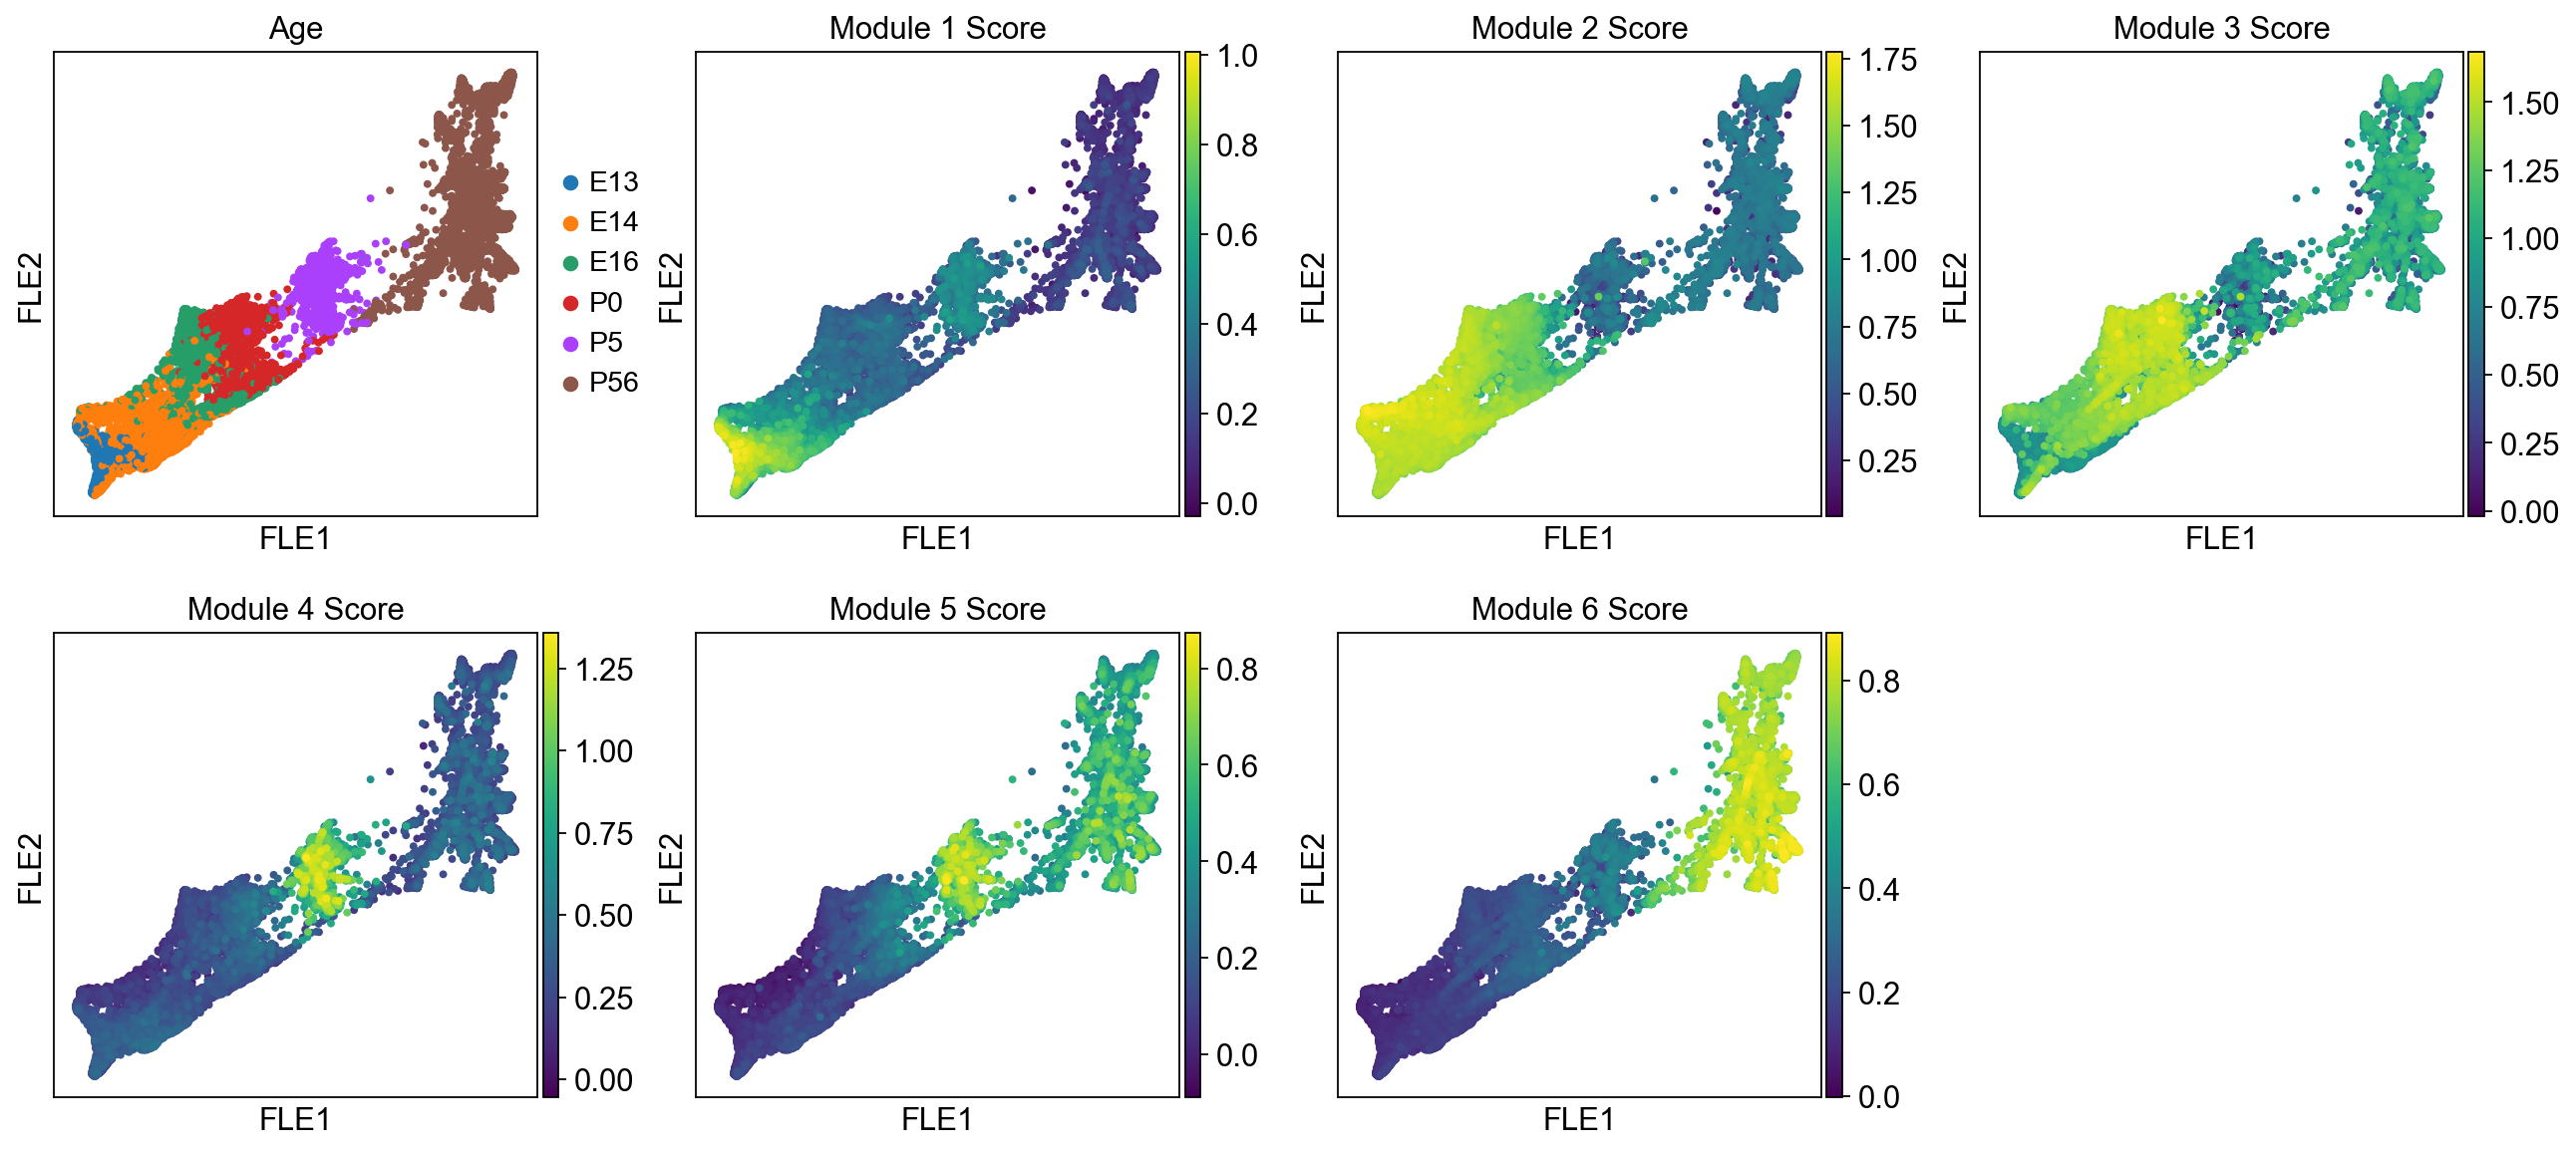

In [103]:
sc.pl.embedding(FLEread,basis='FLE',color=['Age','Module 1 Score','Module 2 Score','Module 3 Score','Module 4 Score', 'Module 5 Score', 'Module 6 Score'], size=50, save='Modules.pdf')

In [104]:
#sc.pl.embedding(FLEread,basis='FLE',color=['Age','Module 1 Score','Module 2 Score','Module 3 Score','Module 4 Score', 'Module 5 Score', 'Module 6 Score'], vmin= 0, vmax=1.5) #, save='ModulesV2.pdf')

In [105]:
#sc.pl.embedding(FLEread,basis='FLE',color=['Age','Module 1 Score','Module 2 Score','Module 3 Score','Module 4 Score', 'Module 5 Score', 'Module 6 Score'], vmin=-0.5, vmax=2.5, save='ModulesV3.pdf')

In [106]:
#sc.pl.embedding(FLEread,basis='FLE',color=['Age','Module 1 Score','Module 2 Score','Module 3 Score','Module 4 Score', 'Module 5 Score', 'Module 6 Score'], vmin=-0.5, vmax=2, save='ModulesV4.pdf')

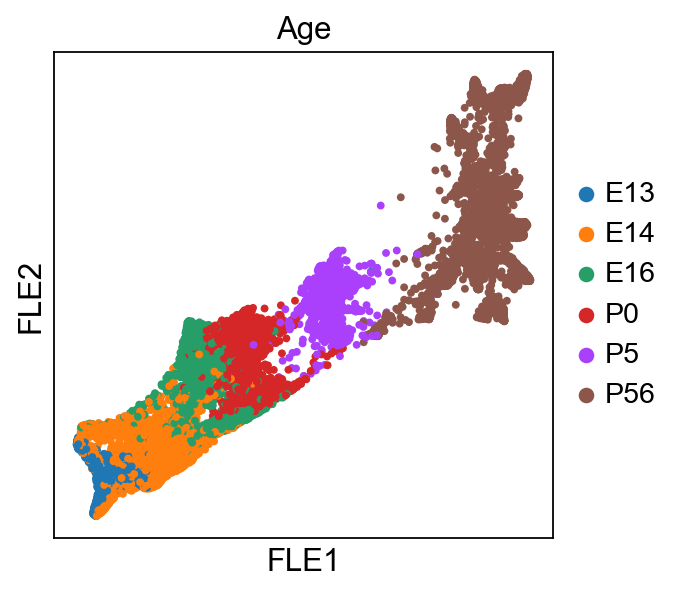

In [107]:
sc.pl.embedding(FLEread,basis='FLE',color=['Age'], size = 50, save='Ages.pdf')

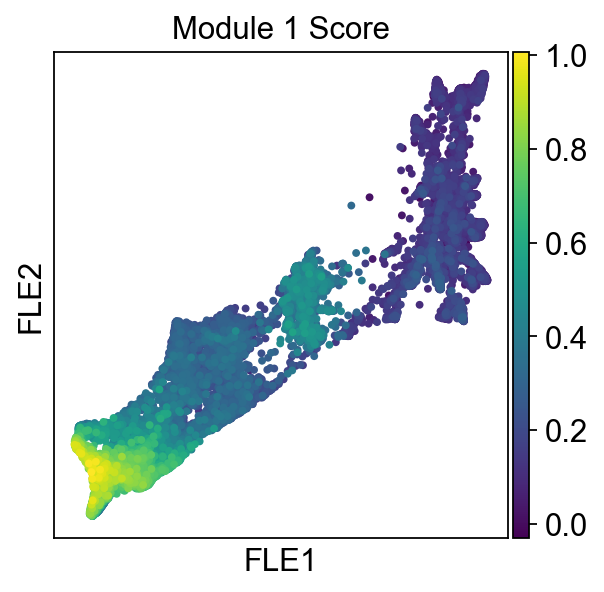

In [108]:
sc.pl.embedding(FLEread,basis='FLE',color=['Module 1 Score'], size = 50, save='Module1.pdf')

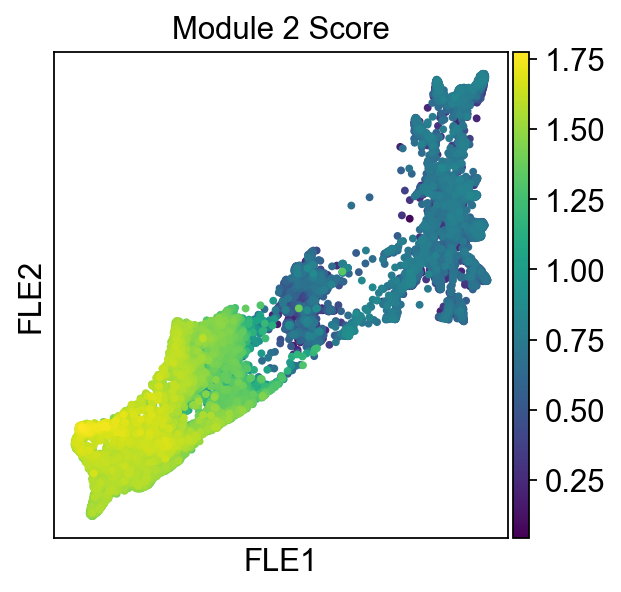

In [109]:
sc.pl.embedding(FLEread,basis='FLE',color=['Module 2 Score'], size = 50,save='Module2.pdf')

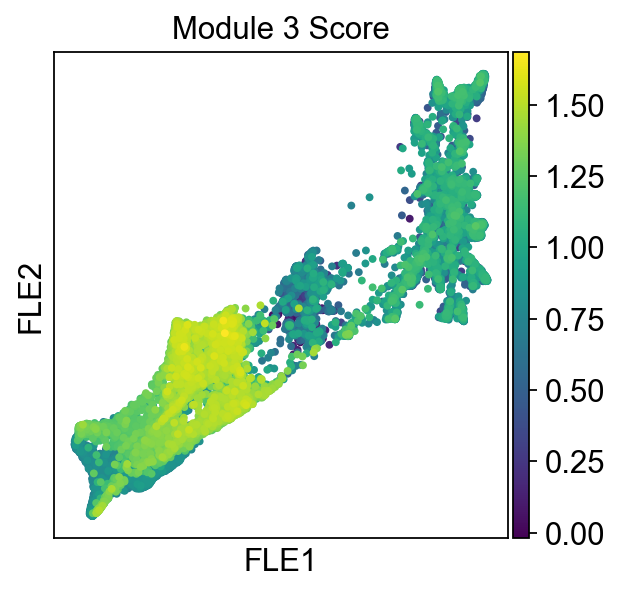

In [110]:
sc.pl.embedding(FLEread,basis='FLE',color=['Module 3 Score'],size = 50, save='Module3.pdf')

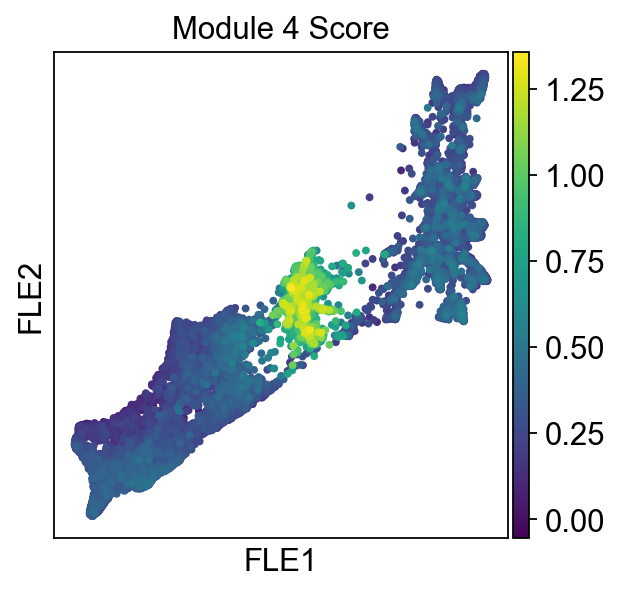

In [111]:
sc.pl.embedding(FLEread,basis='FLE',color=['Module 4 Score'], size = 50,save='Module4.pdf')

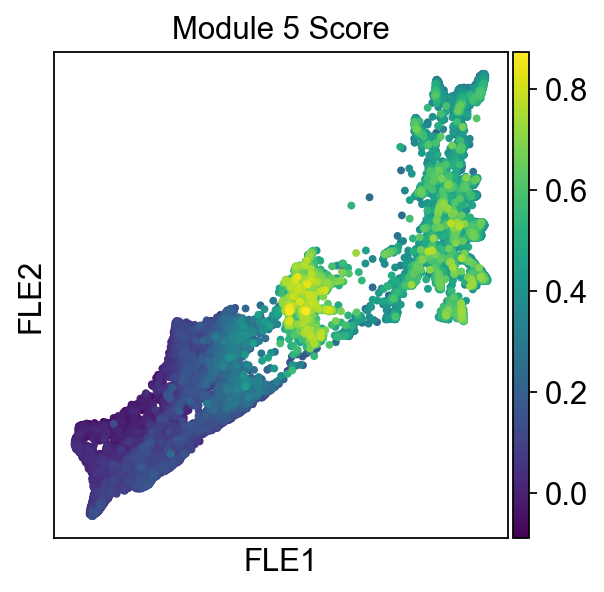

In [112]:
sc.pl.embedding(FLEread,basis='FLE',color=['Module 5 Score'], size = 50,save='Module5.pdf')

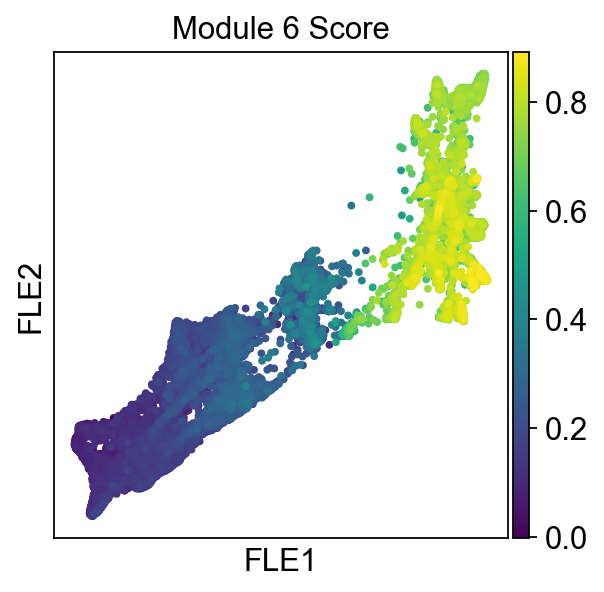

In [113]:
sc.pl.embedding(FLEread,basis='FLE',color=['Module 6 Score'],size = 50, save='Module6.pdf')